# Experiment Pramaters

In [2]:
TRAIN_SPLIT =  0.7 # 0.2
VALIDATION_SPLIT = 0.2 # 0.1
TEST_SPLIT = 0.1 # 0.01
IMAGE_SIZE = 256 # 256

MODE = 'both'
BATCH_SIZE = 16

EPOCHS = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.999
AMP = False
GRADIENT_CLIPPING = 1.0
LOSS_WEIGHT = 1 # 1.5

N_CHANNELS = 3
N_CLASSES = 1
CONDITIONAL = False
DENSE_INPUT = False
EXP_NO = 12

if CONDITIONAL is True:
  N_CHANNELS += 1

SEED = 22

# Imports & Dataset Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
from os import listdir, remove
from os.path import isfile, join

import cv2

import json
import numpy as np
import random
import shutil

In [5]:
import torch

def fix_seed(fixed_seed):

  torch.manual_seed(fixed_seed)
  np.random.seed(fixed_seed)
  random.seed(fixed_seed)
  torch.cuda.manual_seed(fixed_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

fix_seed(SEED)

In [6]:
!mkdir datasets
!cp gdrive/MyDrive/Colab\ Notebooks/rs19_val.zip datasets
!unzip -qo datasets/rs19_val.zip -d datasets/

In [7]:
# !rm -rf datasets/uint8
!rm -rf datasets/authors.txt
!rm -rf datasets/example-vis.py
!rm -rf datasets/license.txt
!rm -rf datasets/readme.txt
!rm -rf datasets/rs19-config.json
!rm -rf datasets/rs19_val.zip

In [8]:
!mv datasets/jpgs/rs19_val datasets/images
!rm -rf datasets/jpgs
!mkdir datasets/labels/

In [9]:
!mv datasets/uint8/rs19_val datasets/
!mv datasets/rs19_val/ datasets/mask

In [10]:
!mkdir datasets/train/
!mkdir datasets/train/images/
!mkdir datasets/train/masks/
!mkdir datasets/val/
!mkdir datasets/val/images/
!mkdir datasets/val/masks/
!mkdir datasets/test/
!mkdir datasets/test/images/
!mkdir datasets/test/masks/

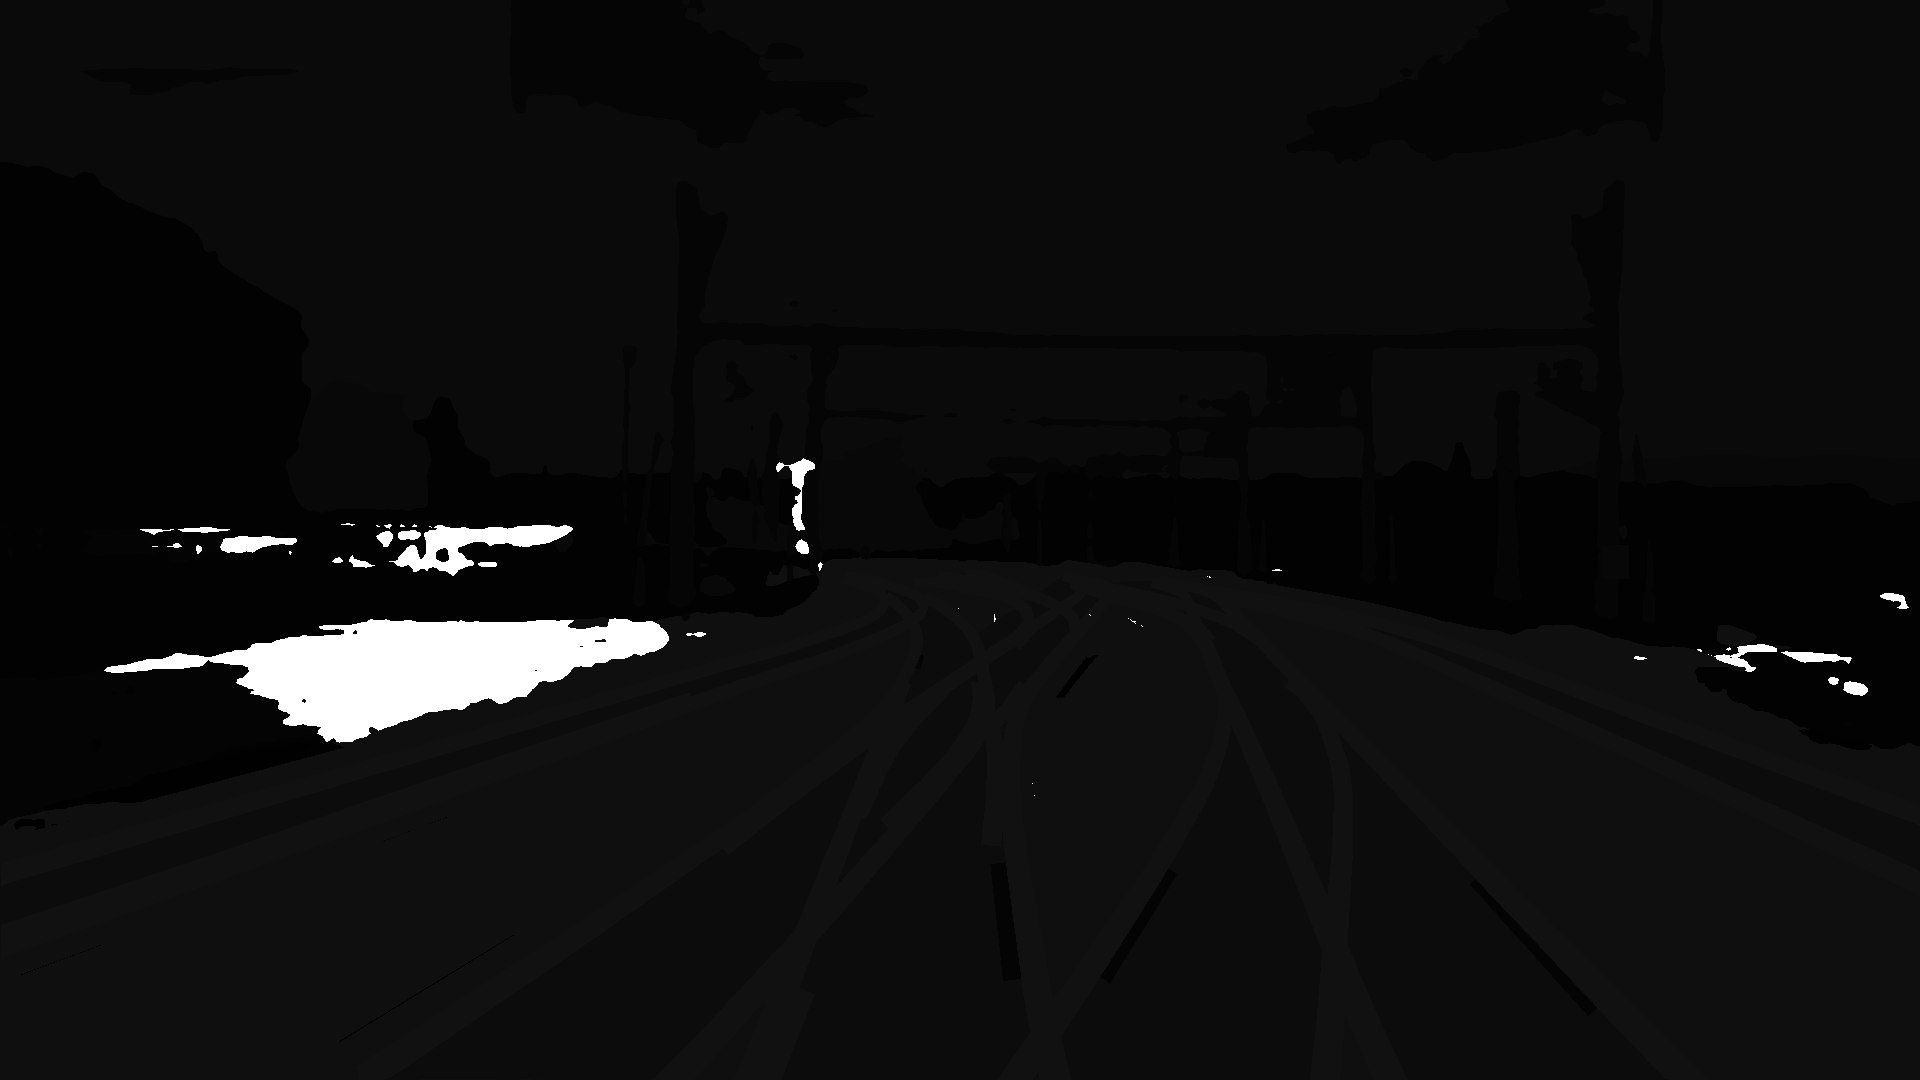

In [11]:
from google.colab.patches import cv2_imshow

full_mask_path = '/content/datasets/mask/rs00007.png'
img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [12]:
mypath = '/content/datasets/images/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
no_files = len(onlyfiles)
print(no_files)

8500


In [13]:
train_images = int(no_files * TRAIN_SPLIT)
val_images = int(no_files * VALIDATION_SPLIT)
test_images = int(no_files * TEST_SPLIT)

image_path = '/content/datasets/images/'
onlyimages = [f for f in listdir(image_path) if isfile(join(image_path, f))]
onlyimages.sort()

mask_path = '/content/datasets/mask/'
onlymasks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
onlymasks.sort()


for pair_no, (image_file, mask_file) in enumerate(zip(onlyimages, onlymasks)):
  # print(pair_no)
  if pair_no < train_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'train/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'train/masks/' + mask_file)
  elif pair_no < train_images + val_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'val/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'val/masks/' + mask_file)
  elif pair_no < train_images + val_images + test_images:
    shutil.move(image_path + image_file, '/content/datasets/' + 'test/images/' + image_file)
    shutil.move(mask_path + mask_file, '/content/datasets/' + 'test/masks/' + mask_file)
  else:
    break

In [14]:
!rm -rf datasets/jsons/
!rm -rf datasets/images/
!rm -rf datasets/labels/
!rm -rf datasets/uint8/
!rm -rf datasets/mask/
!rm -rf datasets/preprocessed/

In [15]:
os.mkdir(f"/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/")
os.mkdir(f"/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/images/")

# Dataloader

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, dataset_path, set_type, input_size = IMAGE_SIZE, mode='track', conditional=True):
      self.path = dataset_path + set_type
      self.image_files = [self.path + 'images/' + f for f in listdir(self.path + 'images/') if isfile(join(self.path + 'images/', f))]
      self.guard_rail_files = self.obtain_rail_mask()
      self.rail_track_files = self.obtain_rail_track_mask()
      self.input_size = input_size
      self.mode = mode
      self.conditional = conditional

    def obtain_rail_mask(self):
      mask_path = self.path + 'masks/'
      onlymasks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]

      rail_masks_path = self.path + 'rail_mask/'

      if not(os.path.exists(rail_masks_path)):
        os.mkdir(rail_masks_path)

        for mask_file in onlymasks:
          full_mask_path = mask_path + mask_file
          img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)

          # img[img == 3] = 17
          # img[img == 12] = 17
          img[img < 17] = 0
          img[img > 18] = 0
          img[img == 17] = 255
          img[img == 18] = 255

          cv2.imwrite(rail_masks_path + mask_file, img)

      return [rail_masks_path + f for f in listdir(rail_masks_path) if isfile(join(rail_masks_path, f))]

    def obtain_rail_track_mask(self):
      mask_path = self.path + 'masks/'
      onlymasks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]

      track_path = self.path + 'track_mask/'

      if not(os.path.exists(track_path)):
        os.mkdir(track_path)

        for mask_file in onlymasks:
          full_mask_path = mask_path + mask_file
          img = cv2.imread(full_mask_path, cv2.IMREAD_GRAYSCALE)

          img[img == 17] = 0
          img[img == 18] = 0
          img[img == 3] = 17
          img[img == 12] = 17
          img[img < 17] = 0
          img[img > 18] = 0
          img[img == 17] = 255

          cv2.imwrite(track_path + mask_file, img)

      return [track_path + f for f in listdir(track_path) if isfile(join(track_path, f))]


    def __len__(self):
      if self.mode == 'track' or self.mode == 'rail':
        return len(self.image_files)
      return 2 * len(self.image_files)

    def __getitem__(self, idx):
      input_image = cv2.imread(self.image_files[idx // 2])
      input_image = input_image[:, 420:1500]
      input_image = cv2.resize(input_image, (self.input_size, self.input_size))

      if self.mode == 'track':
        cond_shape = input_image.shape[:2]
        cond_image = np.ones((cond_shape[0], cond_shape[1], 1))
        output_image = cv2.imread(self.rail_track_files[idx], cv2.IMREAD_GRAYSCALE)
      elif self.mode == 'rail':
        cond_shape = input_image.shape[:2]
        cond_image = np.zeros((cond_shape[0], cond_shape[1], 1))
        output_image = cv2.imread(self.guard_rail_files[idx], cv2.IMREAD_GRAYSCALE)
      else:
        if idx % 2 == 0:
          cond_shape = input_image.shape[:2]
          cond_image = np.zeros((cond_shape[0], cond_shape[1], 1))
          output_image = cv2.imread(self.guard_rail_files[idx // 2], cv2.IMREAD_GRAYSCALE)
        if idx % 2 == 1:
          cond_shape = input_image.shape[:2]
          cond_image = np.ones((cond_shape[0], cond_shape[1], 1))
          output_image = cv2.imread(self.rail_track_files[idx // 2], cv2.IMREAD_GRAYSCALE)

      output_image = output_image[:, 420:1500]

      output_image = cv2.resize(output_image, (self.input_size, self.input_size))
      output_image = np.expand_dims(output_image, axis=2)

      input_image = input_image / 255.0
      output_image = output_image / 255.0
      if self.conditional:
        input_image = np.concatenate((input_image, cond_image), axis=2)

      input_image = np.transpose(input_image, (2, 0, 1))
      output_image = np.transpose(output_image, (2, 0, 1))
      input_image = torch.from_numpy(input_image)
      output_image = torch.from_numpy(output_image)

      batch = {'image': input_image, 'mask': output_image}
      return batch

train_dataset = CustomImageDataset('/content/datasets/','train/', mode=MODE, conditional=CONDITIONAL)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset =  CustomImageDataset('/content/datasets/','val/', mode=MODE, conditional=CONDITIONAL)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples: ", len(train_loader))
print("Val samples: ", len(val_loader))

Train samples:  744
Val samples:  213


# Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, conditional=True, dense_input=False, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dense_input = dense_input
        self.inc = (DoubleConv(n_channels, 64))
        self.emb = nn.Embedding(n_classes + 1, IMAGE_SIZE * IMAGE_SIZE)
        self.conditional = conditional
        extra_input_channels = 0
        if self.dense_input:
          self.emb2 = nn.Embedding(n_classes + 1, IMAGE_SIZE // 2 * IMAGE_SIZE // 2)
          self.emb3 = nn.Embedding(n_classes + 1, IMAGE_SIZE // 4 * IMAGE_SIZE // 4)
          self.emb4 = nn.Embedding(n_classes + 1, IMAGE_SIZE // 8 * IMAGE_SIZE // 8)
          self.emb5 = nn.Embedding(n_classes + 1, IMAGE_SIZE // 16 * IMAGE_SIZE // 16)
          extra_input_channels = 1
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128 + extra_input_channels, 256))
        self.down3 = (Down(256 + extra_input_channels, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512 + extra_input_channels, 1024 // factor))
        self.up1 = (Up(1024 + extra_input_channels, 512  // factor + extra_input_channels, bilinear))
        self.up2 = (Up(512 + extra_input_channels, 256  // factor + extra_input_channels, bilinear))
        self.up3 = (Up(256 + extra_input_channels, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        if self.conditional:
          cond = x[:, 3, :, :]
          x = x[:, :3, :, :]
          labels = cond[:, 0, 0].int()
          embeddings = self.emb(labels)
          reshaped_embeddings = torch.reshape(embeddings, (labels.shape[0], 1, IMAGE_SIZE, IMAGE_SIZE))
          reshaped_embeddings = reshaped_embeddings.float()
          x = torch.cat((x, reshaped_embeddings), 1)
        if self.conditional and self.dense_input:
          reshaped_embeddings2 = torch.reshape(self.emb2(labels), (labels.shape[0], 1, IMAGE_SIZE // 2, IMAGE_SIZE // 2)).float()
          reshaped_embeddings3 = torch.reshape(self.emb3(labels), (labels.shape[0], 1, IMAGE_SIZE // 4, IMAGE_SIZE // 4)).float()
          reshaped_embeddings4 = torch.reshape(self.emb4(labels), (labels.shape[0], 1, IMAGE_SIZE // 8, IMAGE_SIZE // 8)).float()
          reshaped_embeddings5 = torch.reshape(self.emb5(labels), (labels.shape[0], 1, IMAGE_SIZE // 16, IMAGE_SIZE // 16)).float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
        if self.conditional and self.dense_input:
          x2 = torch.cat((x2, reshaped_embeddings2), 1)
        x3 = self.down2(x2)
        if self.conditional and self.dense_input:
          x3 = torch.cat((x3, reshaped_embeddings3), 1)
        x4 = self.down3(x3)
        if self.conditional and self.dense_input:
          x4 = torch.cat((x4, reshaped_embeddings4), 1)
        x5 = self.down4(x4)
        if self.conditional and self.dense_input:
          x5 = torch.cat((x5, reshaped_embeddings5), 1)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Train

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES, conditional=CONDITIONAL, dense_input=DENSE_INPUT, bilinear=False)
model = model.to(memory_format=torch.channels_last)
model.to(device=device)

total_params = sum(p.numel() for p in model.parameters())
print("Model Params: ", total_params)

Using device cuda
Model Params:  31168705


In [20]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single maskâ
    assert input.size() == target.size()
    assert input.dim() == 4 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def compute_iou_score(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):

    # Ensure the input and target tensors have the same size and are 4-dimensional (batch, channel, height, width)
    assert input.size() == target.size()
    assert input.dim() == 4 or not reduce_batch_first

    # Determine the dimensions to sum over
    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    # Calculate the intersection and union
    intersection = (input * target).sum(dim=sum_dim)
    union = input.sum(dim=sum_dim) + target.sum(dim=sum_dim) - intersection

    # Handle the case where the union is zero to avoid division by zero
    union = torch.where(union == 0, intersection + epsilon, union)

    # Compute the IoU score
    iou = (intersection + epsilon) / (union + epsilon)

    # Return the mean IoU score
    return iou.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

def multiclass_iou_score(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
  return compute_iou_score(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [21]:
@torch.inference_mode()
def evaluate(net, dataloader, device, amp, epoch):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        total_loss = 0
        for no_batch, batch in enumerate(tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0, leave=False)):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)
            if model.n_classes == 1:
                loss = criterion(mask_pred, mask_true.float())
                # loss += dice_loss(F.sigmoid(mask_pred), mask_true.float(), multiclass=False)
            else:
                loss = criterion(mask_pred, mask_true)
                '''
                loss += dice_loss(
                    F.softmax(mask_pred, dim=1).float(),
                    F.one_hot(mask_true, model.n_classes).permute(0, 3, 1, 2).float(),
                    multiclass=True
                )
                '''
            total_loss += loss

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
                iou_score += compute_iou_score(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)
                # VALIDATE THIS SCORE
                iou_score += compute_iou_score(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

            if no_batch == 0:
              for mp_index, (mp, mt) in enumerate(zip(mask_pred, mask_true)):
                mp = mp.cpu().detach().numpy() * 255.0
                mp = np.reshape(mp, (IMAGE_SIZE, IMAGE_SIZE, 1))
                mt = mt.cpu().detach().numpy() * 255.0
                mt = np.reshape(mt, (IMAGE_SIZE, IMAGE_SIZE, 1))
                cv2.imwrite(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/images/{epoch}_{no_batch}_{mp_index}_val_pred.png', mp)
                cv2.imwrite(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/images/{epoch}_{no_batch}_{mp_index}_val_true.png', mt)

    net.train()
    return dice_score / max(num_val_batches, 1), total_loss / max(num_val_batches, 1), iou_score / max(num_val_batches, 1)

In [ ]:
from tqdm import tqdm
from torch import optim


#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=AMP)
# criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss(pos_weight=torch.tensor([LOSS_WEIGHT]).to(device))
global_step = 0

n_val = int(len(val_dataset))
n_train = int(len(train_dataset))

history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [], 'train_iou':[], 'val_iou':[]}

# 5. Begin training
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0
    train_dice_score = 0
    train_iou_score = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{EPOCHS}', unit='img') as pbar:
        for no_batch, batch in enumerate(train_loader):
            images, true_masks = batch['image'], batch['mask']

            assert images.shape[1] == model.n_channels, \
                f'Network has been defined with {model.n_channels} input channels, ' \
                f'but loaded images have {images.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=AMP):
                masks_pred = model(images)

                if model.n_classes == 1:
                    loss = criterion(masks_pred, true_masks.float())
                    # loss += dice_loss(F.sigmoid(masks_pred), true_masks.float(), multiclass=False)
                else:
                    loss = criterion(masks_pred, true_masks.float())
                    '''
                    loss += dice_loss(
                        F.softmax(masks_pred, dim=1).float(),
                        F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                    )
                    '''

                if model.n_classes == 1:
                  assert true_masks.min() >= 0 and true_masks.max() <= 1, 'True mask indices should be in [0, 1]'
                  mask_pred = (F.sigmoid(masks_pred) > 0.5).float()

                  train_dice_score += dice_coeff(mask_pred, true_masks, reduce_batch_first=False).item()
                  train_iou_score += compute_iou_score(mask_pred, true_masks, reduce_batch_first=False).item()
                else:
                  assert true_masks.min() >= 0 and true_masks.max() < model.n_classes, 'True mask indices should be in [0, n_classes['
                  # convert to one-hot format
                  true_masks = F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float()
                  mask_pred = F.one_hot(masks_pred.argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).float()

                  train_dice_score += multiclass_dice_coeff(mask_pred[:, 1:], true_masks[:, 1:], reduce_batch_first=False).item()
                  # VALIDATE THIS SCORE
                  train_iou_score += compute_iou_score(mask_pred[:, 1:], true_masks[:, 1:], reduce_batch_first=False).item()


                if no_batch == 0:
                  for mp_index, (mp, mt) in enumerate(zip(mask_pred, true_masks)):
                    mp = mp.cpu().detach().numpy() * 255.0
                    mp = np.reshape(mp, (IMAGE_SIZE, IMAGE_SIZE, 1))
                    mt = mt.cpu().detach().numpy() * 255.0
                    mt = np.reshape(mt, (IMAGE_SIZE, IMAGE_SIZE, 1))
                    cv2.imwrite(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/images/{epoch}_{no_batch}_{mp_index}_train_pred.png', mp)
                    cv2.imwrite(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/images/{epoch}_{no_batch}_{mp_index}_train_true.png', mt)

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix(**{'loss (batch)': loss.item()})

            # scheduler.step(val_score)

        # Evaluation round
        histograms = {}
        for tag, value in model.named_parameters():
            tag = tag.replace('/', '.')

        val_score, val_loss, iou_score = evaluate(model, val_loader, device, AMP, epoch)
        train_loss = epoch_loss / max(1, len(train_loader))
        train_dice_score = train_dice_score / max(1, len(train_loader))
        train_iou_score = train_iou_score / max(1, len(train_loader))

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss.item())
        history['train_dice'].append(train_dice_score)
        history['val_dice'].append(val_score.item())
        history['train_iou'].append(train_iou_score)
        history['val_iou'].append(iou_score.item())

        print(f'Train Dice score: {train_dice_score} Train IoU score: {train_iou_score}')
        print(f'Validation Dice score: {val_score} Val IoU score: {iou_score}')
        print(f'Train loss: {train_loss} Validation loss: {val_loss}')

Epoch 1/20: 100%|██████████| 11900/11900 [11:40<00:00, 17.00img/s, loss (batch)=0.326]


Train Dice score: 0.014451967141985947 Train IoU score: 0.007707480802788548
Validation Dice score: 0.0008068683091551065 Val IoU score: 0.00042897058301605284
Train loss: 0.3901000417047931 Validation loss: 0.32788941264152527


Epoch 2/20: 100%|██████████| 11900/11900 [11:37<00:00, 17.05img/s, loss (batch)=0.304]


Train Dice score: 0.004907828560294088 Train IoU score: 0.002528666932209485
Validation Dice score: 0.005463200155645609 Val IoU score: 0.002786915749311447
Train loss: 0.3090206707517306 Validation loss: 0.2907273769378662


Epoch 3/20: 100%|██████████| 11900/11900 [11:38<00:00, 17.04img/s, loss (batch)=0.248]


Train Dice score: 0.005788080928122723 Train IoU score: 0.0029784183493314874
Validation Dice score: 0.003697630949318409 Val IoU score: 0.0018680699868127704
Train loss: 0.2783422120796737 Validation loss: 0.2669815421104431


Epoch 4/20: 100%|██████████| 11900/11900 [11:37<00:00, 17.07img/s, loss (batch)=0.253]


Train Dice score: 0.0024685795208960115 Train IoU score: 0.0012582374411578127
Validation Dice score: 0.0015480756992474198 Val IoU score: 0.000775046821217984
Train loss: 0.2565450114348242 Validation loss: 0.25023138523101807


Epoch 5/20: 100%|██████████| 11900/11900 [11:36<00:00, 17.08img/s, loss (batch)=0.231]


Train Dice score: 0.0015080286428628352 Train IoU score: 0.0007635389610596273
Validation Dice score: 0.0016689238836988807 Val IoU score: 0.00084166374290362
Train loss: 0.23931286992725506 Validation loss: 0.2346985936164856


Epoch 6/20: 100%|██████████| 11900/11900 [11:36<00:00, 17.07img/s, loss (batch)=0.195]


Train Dice score: 0.000606652079549014 Train IoU score: 0.0003055778638946758
Validation Dice score: 0.0016928710974752903 Val IoU score: 0.0008487107697874308
Train loss: 0.225749602881811 Validation loss: 0.22083227336406708


Epoch 7/20: 100%|██████████| 11900/11900 [11:36<00:00, 17.09img/s, loss (batch)=0.207]


Train Dice score: 0.0005141010423748898 Train IoU score: 0.00025762768244563984
Validation Dice score: 0.0016481071943417192 Val IoU score: 0.0008345777168869972
Train loss: 0.2148195255587819 Validation loss: 0.21192152798175812


Epoch 8/20:  72%|███████▏  | 8624/11900 [07:05<02:41, 20.30img/s, loss (batch)=0.207]

In [ ]:
import matplotlib.pyplot as plt

epochs = [e for e in range(len(history['train_loss']))]

plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()
plt.savefig(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/loss.png')

In [ ]:
plt.plot(epochs, history['train_dice'], 'b-', label='Train Dice')
plt.plot(epochs, history['val_dice'], 'r-', label='Valid Dice')
plt.title('Dice Evolution')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
# plt.show()
plt.savefig(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/dice.png')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, history['train_iou'], 'b-', label='Train IoU')
plt.plot(epochs, history['val_iou'], 'r-', label='Valid IoU')
plt.title('IoU Evolution')
plt.xlabel('Epochs')
plt.ylabel('IoU')
# plt.legend()
plt.savefig(f'/content/gdrive/MyDrive/New Exps/Samples/{EXP_NO}/iou.png')

In [ ]:
print("Best Loss", min(history['train_loss']), min(history['val_loss']))
print("Best Dice", max(history['train_dice']), max(history['val_dice']))
print("Best IoU", max(history['train_iou']), max(history['val_iou']))